In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils

# REINFORCE Algorithm

In [23]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.net(x)

In [24]:
class REINFORCE:
    """ REINFORCE algorithm """
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 device):
        
        self.gamma = gamma
        self.device = device

        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)
    
    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()
    
    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):
            reward = reward_list[i]
            state = torch.tensor([state_list[i]], dtype=torch.float).to(self.device)
            action = torch.tensor([action_list[i]], dtype=torch.int64).view(-1, 1).to(self.device)
            log_prob = torch.log(self.policy_net(state).gather(1, action))
            G = reward + self.gamma * G
            loss = -G * log_prob
            loss.backward()
        self.optimizer.step()


In [25]:
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)

seed = 0
env.reset(seed=seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma, device)

/home/user/.local/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [26]:
return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'rewards': [],
                'next_states': [],
                'dones': []
            }
            reset_output = env.reset()
            state = reset_output[0] if isinstance(reset_output, tuple) else reset_output
            done = False

            while not done:
                action = agent.take_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['rewards'].append(reward)
                transition_dict['next_states'].append(next_state)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            
            return_list.append(episode_return)
            agent.update(transition_dict)

            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return': '%.3f' % (np.mean(return_list[-10:]))
                })
            pbar.update(1)

Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 9: 100%|██████████| 100/100 [00:09<00:00, 10.38it/s, episode=1000, return=142.200]


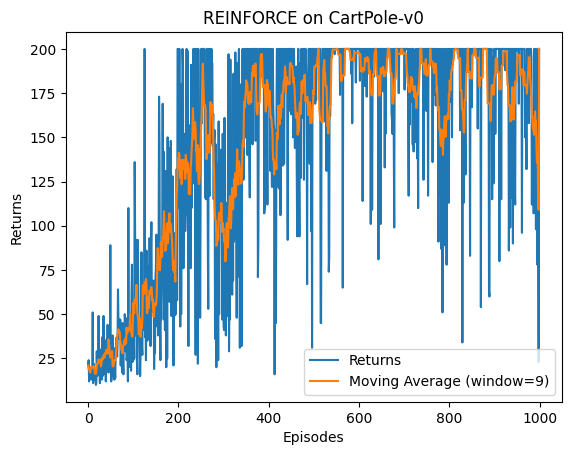

In [27]:
episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 9)

plt.plot(episodes_list, return_list, label='Returns')
plt.plot(episodes_list, mv_return, label='Moving Average (window=9)')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

